In [153]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from functools import reduce
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer

In [2]:
with open('feedback.csv', 'r') as file:
    lines = file.readlines()
    lines = [line[:-1] for line in lines]
    cols = lines[0].split(',')
    lines = lines[1:]
    lines = [line.split(',') for line in lines]
    lines = [[*line[:4], " ".join(line[4:])] for line in lines]

dataset = pd.DataFrame(lines, columns=cols)

In [3]:
dataset.head()

,rating,product_id,name,date,feedback
0,1,8342,Александр,2017-04-12,"""6 входов предохранитель"" ""искрит при включен..."
1,5,8342,Елена,2015-08-04,"""Я являюсь пользователем Пилотов уже больше 10..."
2,5,5311,Леонид,2017-07-16,"""хорошо мелет"" ""маркий остаются следы"" ""Испол..."
3,4,5311,Сергей,2017-06-28,"Компактная ""Не нашел"" ""Работает на ура. В инст..."
4,5,5311,Ольга,2017-01-21,"""Цена и качество"" Нет ""В использовании 2 месяц..."


In [4]:
def process_feedback(text: str):
    text = text.replace(',', ' ')
    return ''.join([c if c.isdigit() or c.isalpha() else ' ' for c in text.lower()])

dataset['feedback'] = dataset['feedback'].apply(process_feedback)
dataset['rating'] = dataset['rating'].astype(float)

In [5]:
dataset.head()

,rating,product_id,name,date,feedback
0,1.0,8342,Александр,2017-04-12,6 входов предохранитель искрит при включен...
1,5.0,8342,Елена,2015-08-04,я являюсь пользователем пилотов уже больше 10...
2,5.0,5311,Леонид,2017-07-16,хорошо мелет маркий остаются следы испол...
3,4.0,5311,Сергей,2017-06-28,компактная не нашел работает на ура в инст...
4,5.0,5311,Ольга,2017-01-21,цена и качество нет в использовании 2 месяц...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['feedback'], dataset['rating'], test_size=0.3)

# Stemming + word encoding

In [7]:
from itertools import chain


def stem(data):
    stemmer = SnowballStemmer('russian')
    return data.apply(lambda text: [stemmer.stem(word) for word in text.split(' ')])

def clear_words(data):
    return data.apply(lambda l: [word for word in l if word.isalpha()])

def encode_words(train, test):
    train = clear_words(train)
    test = clear_words(test)
    
    words = reduce(lambda x, y: set(x).union(set(y)), chain(train, test))
    words_map = {word: i + 2 for i, word in enumerate(words)}
    print(len(words) + 2) 
    
    mapping_func = lambda l: [words_map[word] for word in l] + [0]
    return train.apply(mapping_func), test.apply(mapping_func)

def equalize(train, test, length):
    eq_func = lambda l: l[:length] if len(l) >= length else l + [1] * (length - len(l))
    return train.apply(eq_func), test.apply(eq_func)

def clear_zero_lengths(data):
    return data.where(data.apply(len) != 0)

def to_array(series):
    return np.array(list(series.values))

In [10]:
X_train_stem = stem(X_train)
X_test_stem = stem(X_test)

In [11]:
X_train_encoded, X_test_encoded = encode_words(X_train_stem, X_test_stem)

25816


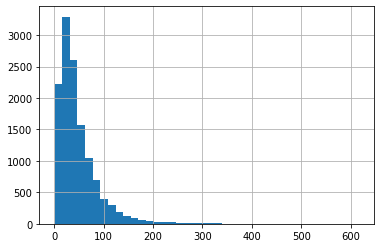

In [13]:
X_train_encoded.apply(len).hist(bins=40)

In [14]:
X_train_encoded.apply(len).median(), X_test_encoded.apply(len).median()

(36.0, 37.0)

In [15]:
X_train_tr, X_test_tr = equalize(X_train_encoded, X_test_encoded, length=256)

In [16]:
X_train_final = to_array(X_train_tr)
X_test_final = to_array(X_test_tr)

# Bidirectional LSTM (continious target)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D

In [48]:
model = tf.keras.Sequential()
model.add(Embedding(25816, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss=tf.keras.losses.mean_squared_error, metrics=[tf.keras.metrics.mean_squared_error])
model.fit(X_train_final, y_train, batch_size=128, epochs=4, validation_split=0.1)

Train on 11555 samples, validate on 1284 samples
Epoch 1/4
11555/11555 [==============================] - 86s 7ms/sample - loss: 2.0031 - mean_squared_error: 2.0031 - val_loss: 1.0864 - val_mean_squared_error: 1.0864
Epoch 2/4
11555/11555 [==============================] - 84s 7ms/sample - loss: 0.8968 - mean_squared_error: 0.8968 - val_loss: 0.8681 - val_mean_squared_error: 0.8681
Epoch 3/4
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.5702 - mean_squared_error: 0.5702 - val_loss: 0.8785 - val_mean_squared_error: 0.8785
Epoch 4/4
11555/11555 [==============================] - 82s 7ms/sample - loss: 0.4433 - mean_squared_error: 0.4433 - val_loss: 0.8592 - val_mean_squared_error: 0.8592


In [49]:
predictions = model.predict(X_test_final)
mean_squared_error(predictions, y_test)

0.9129527709337447

In [50]:
print(classification_report(y_test.round().astype('int'), predictions.round().astype('int')))
accuracy_score(y_test.round().astype('int'), predictions.round().astype('int'))

              precision    recall  f1-score   support

           1       0.53      0.26      0.35       521
           2       0.20      0.33      0.25       314
           3       0.20      0.23      0.22       447
           4       0.26      0.34      0.29       924
           5       0.83      0.77      0.80      3297

   micro avg       0.58      0.58      0.58      5503
   macro avg       0.41      0.39      0.38      5503
weighted avg       0.62      0.58      0.59      5503



0.5785934944575686

# Bidirectional LSTM (multiclass target)

In [18]:
y_train_ohe = OneHotEncoder().fit_transform(y_train.astype('float').round().astype('int').reshape(-1, 1)).todense()
y_test_ohe = OneHotEncoder().fit_transform(y_test.astype('float').round().astype('int').reshape(-1, 1)).todense()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/

In [52]:
model = tf.keras.Sequential()
model.add(Embedding(28557, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.fit(X_train_final, y_train_ohe, batch_size=128, epochs=3, validation_split=0.1)

Train on 11555 samples, validate on 1284 samples
Epoch 1/3
11555/11555 [==============================] - 84s 7ms/sample - loss: 1.0461 - accuracy: 0.6168 - val_loss: 0.8824 - val_accuracy: 0.6542
Epoch 2/3
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.7723 - accuracy: 0.7032 - val_loss: 0.8920 - val_accuracy: 0.6480
Epoch 3/3
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.5872 - accuracy: 0.7797 - val_loss: 0.9577 - val_accuracy: 0.6410


In [53]:
predictions = model.predict(X_test_final).argmax(axis=1) + 1

In [54]:
print(classification_report(y_test.round().astype('int'), predictions))
accuracy_score(y_test.round().astype('int'), predictions)

              precision    recall  f1-score   support

           1       0.49      0.51      0.50       521
           2       0.22      0.06      0.09       314
           3       0.27      0.13      0.17       447
           4       0.31      0.47      0.37       924
           5       0.81      0.80      0.80      3297

   micro avg       0.62      0.62      0.62      5503
   macro avg       0.42      0.39      0.39      5503
weighted avg       0.62      0.62      0.61      5503



0.6180265309831001

# Bidirectional LSTM (binary target)

In [55]:
y_train_bin = (y_train.round() > 3).astype('int')
y_test_bin = (y_test.round() > 3).astype('int')

In [59]:
model = tf.keras.Sequential()
model.add(Embedding(28557, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
model.fit(X_train_final, y_train_bin, batch_size=64, epochs=3, validation_split=0.2)

Train on 10271 samples, validate on 2568 samples
Epoch 1/3
10271/10271 [==============================] - 98s 10ms/sample - loss: 0.4115 - accuracy: 0.8258 - val_loss: 0.3358 - val_accuracy: 0.8575
Epoch 2/3
10271/10271 [==============================] - 100s 10ms/sample - loss: 0.2275 - accuracy: 0.9170 - val_loss: 0.3436 - val_accuracy: 0.8621
Epoch 3/3
10271/10271 [==============================] - 100s 10ms/sample - loss: 0.1196 - accuracy: 0.9605 - val_loss: 0.4021 - val_accuracy: 0.8567


In [60]:
predictions = model.predict(X_test_final)

In [61]:
print(classification_report(y_test_bin, predictions > 0.5))
print(roc_auc_score(y_test_bin, predictions))
print(accuracy_score(y_test_bin, predictions > 0.5))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      1282
           1       0.88      0.95      0.91      4221

   micro avg       0.86      0.86      0.86      5503
   macro avg       0.82      0.76      0.78      5503
weighted avg       0.85      0.86      0.85      5503

0.8971338242300124
0.8597128838815191


# Fasttext model with multiclass target

In [14]:
from functools import partial

def get_row_ngrams(row, ngram_range):
    return set(zip(*[row[i:] for i in range(ngram_range)]))


def get_all_ngrams(dataset, ngram_range):
    ngramed_dataset = map(partial(get_row_ngrams, ngram_range=ngram_range), dataset)
    return reduce(lambda x, y: x.union(y), ngramed_dataset)


def build_ngram_mapping(train, test, ngram_range):
    max_features = max(train.apply(lambda x: max(x)).max(), test.apply(lambda x: max(x)).max())
    train_ngrams = get_all_ngrams(train, ngram_range)
    test_ngrams = get_all_ngrams(test, ngram_range)
    return {ngram: i + max_features + 1 for i, ngram in enumerate(train_ngrams.union(test_ngrams))}


def add_ngrams_to_row(row, ngram_mapping, ngram_range):
    existing_ngrams = get_row_ngrams(row, ngram_range)
    return list(row) + [ngram_mapping[ngram] for ngram in existing_ngrams]


def add_ngrams_to_dataset(dataset, ngram_mapping, ngram_range):
    return dataset.apply(lambda row: add_ngrams_to_row(row, ngram_mapping, ngram_range))


def add_ngrams(train, test, ngram_range=2):
    ngram_mapping = build_ngram_mapping(train, test, ngram_range)
    return add_ngrams_to_dataset(train, ngram_mapping, ngram_range), add_ngrams_to_dataset(test, ngram_mapping, ngram_range)

In [70]:
X_train_for_ngrams = pd.Series(list(pad_sequences(X_train_encoded, maxlen=128)))
X_test_for_ngrams = pd.Series(list(pad_sequences(X_test_encoded, maxlen=128)))

## Bi-grams

In [73]:
X_train_ngramed, X_test_ngramed = add_ngrams(X_train_for_ngrams, X_test_for_ngrams, ngram_range=2) 

In [74]:
X_train_ngramed = pad_sequences(X_train_ngramed, maxlen=256)
X_test_ngramed = pad_sequences(X_test_ngramed, maxlen=256)

In [75]:
max_features = max(X_train_ngramed.max(), X_test_ngramed.max()) + 1
max_features

377631

In [78]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=256))
model.add(GlobalAveragePooling1D())
model.add(Dense(5, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

model.fit(X_train_ngramed, y_train_ohe, batch_size=128, epochs=4, validation_split=0.2)

Train on 10271 samples, validate on 2568 samples
Epoch 1/4
10271/10271 [==============================] - 50s 5ms/sample - loss: 1.1826 - accuracy: 0.5849 - val_loss: 1.0222 - val_accuracy: 0.6121
Epoch 2/4
10271/10271 [==============================] - 50s 5ms/sample - loss: 0.7723 - accuracy: 0.7019 - val_loss: 0.8307 - val_accuracy: 0.6686
Epoch 3/4
10271/10271 [==============================] - 50s 5ms/sample - loss: 0.3723 - accuracy: 0.8933 - val_loss: 0.8206 - val_accuracy: 0.6807
Epoch 4/4
10271/10271 [==============================] - 49s 5ms/sample - loss: 0.1625 - accuracy: 0.9709 - val_loss: 0.8445 - val_accuracy: 0.6733


In [79]:
predictions = model.predict(X_test_ngramed).argmax(axis=1) + 1
print(classification_report(y_test.round().astype('int'), predictions))
accuracy_score(y_test.round().astype('int'), predictions)

              precision    recall  f1-score   support

           1       0.57      0.50      0.54       527
           2       0.28      0.06      0.10       311
           3       0.30      0.24      0.27       449
           4       0.42      0.39      0.40       904
           5       0.80      0.91      0.85      3312

   micro avg       0.68      0.68      0.68      5503
   macro avg       0.47      0.42      0.43      5503
weighted avg       0.64      0.68      0.66      5503



0.6821733599854625

## Tri-grams

In [82]:
X_train_ngramed, X_test_ngramed = add_ngrams(X_train_for_ngrams, X_test_for_ngrams, ngram_range=3)
X_train_ngramed = pad_sequences(X_train_ngramed, maxlen=512)
X_test_ngramed = pad_sequences(X_test_ngramed, maxlen=512)

In [83]:
max_features = max(X_train_ngramed.max(), X_test_ngramed.max()) + 1
max_features

710743

In [90]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=512))
model.add(GlobalAveragePooling1D())
model.add(Dense(5, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.005), metrics=['accuracy'])

model.fit(X_train_ngramed, y_train_ohe, batch_size=128, epochs=6, validation_split=0.2)

Train on 10271 samples, validate on 2568 samples
Epoch 1/6
10271/10271 [==============================] - 93s 9ms/sample - loss: 1.2310 - accuracy: 0.5863 - val_loss: 1.1565 - val_accuracy: 0.6083
Epoch 2/6
10271/10271 [==============================] - 94s 9ms/sample - loss: 1.1464 - accuracy: 0.5922 - val_loss: 1.1086 - val_accuracy: 0.6083
Epoch 3/6
10271/10271 [==============================] - 93s 9ms/sample - loss: 0.9977 - accuracy: 0.6097 - val_loss: 1.0060 - val_accuracy: 0.6180
Epoch 4/6
10271/10271 [==============================] - 93s 9ms/sample - loss: 0.7613 - accuracy: 0.7071 - val_loss: 0.9455 - val_accuracy: 0.6293
Epoch 5/6
10271/10271 [==============================] - 92s 9ms/sample - loss: 0.5426 - accuracy: 0.8201 - val_loss: 0.8849 - val_accuracy: 0.6515
Epoch 6/6
10271/10271 [==============================] - 92s 9ms/sample - loss: 0.3820 - accuracy: 0.9008 - val_loss: 0.8769 - val_accuracy: 0.6550


In [91]:
gc.collect()

14

In [92]:
predictions = model.predict(X_test_ngramed).argmax(axis=1) + 1
print(classification_report(y_test.round().astype('int'), predictions))
accuracy_score(y_test.round().astype('int'), predictions)

              precision    recall  f1-score   support

           1       0.51      0.36      0.42       527
           2       0.00      0.00      0.00       311
           3       0.31      0.08      0.12       449
           4       0.44      0.22      0.30       904
           5       0.70      0.96      0.81      3312

   micro avg       0.65      0.65      0.65      5503
   macro avg       0.39      0.32      0.33      5503
weighted avg       0.56      0.65      0.58      5503



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6538251862620389

# Using pre-generated Russian W2V embeddings

In [8]:
import requests
import gensim
from pymystem3 import Mystem

### Stemming words using Mystem

In [9]:
mapping_url = 'https://raw.githubusercontent.com/akutuzov/universal-pos-tags/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map'

mystem2upos = {}
r = requests.get(mapping_url, stream=True)
for pair in r.text.split('\n'):
    pair = pair.split()
    if len(pair) > 1:
        mystem2upos[pair[0]] = pair[1]

class Preprocessor:
    def __init__(self, mapping):
        self.m = Mystem()
        self.mapping = mapping
        
    def process(self, text, postags=True):
        processed = self.m.analyze(text)
        tagged = []
        for w in processed:
            try:
                lemma = w["analysis"][0]["lex"].lower().strip()
                pos = w["analysis"][0]["gr"].split(',')[0]
                pos = pos.split('=')[0].strip()
                pos = self.mapping.get(pos, 'X')
                tagged.append(lemma.lower() + '_' + pos)
            except:
                continue
        if not postags:
            tagged = [t.split('_')[0] for t in tagged]
        return tagged

processor = Preprocessor(mystem2upos)

In [10]:
X_train_mystem = X_train.apply(lambda string: processor.process(string))
X_test_mystem = X_test.apply(lambda string: processor.process(string))

### Building dictionary and encoding datasets

In [11]:
words = reduce(lambda x, y: set(x).union(set(y)), chain(X_train_mystem, X_test_mystem))

In [12]:
dictionary = {pair[1]: pair[0] + 1 for pair in enumerate(words)}

In [13]:
def encode(dataset):
    return dataset.apply(lambda words: [dictionary[word] for word in words])

X_train_w2v = encode(X_train_mystem)
X_test_w2v = encode(X_test_mystem)

In [14]:
X_train_w2v = pad_sequences(X_train_w2v, maxlen=256)
X_test_w2v = pad_sequences(X_test_w2v, maxlen=256)

### Downloading and building pre-trained embeddings

In [20]:
from editdistance import distance

In [38]:
def prepare_vocab(vocab):
    first_letters = set([word[0] for word in vocab])
    return {first: [word for word in vocab if word[0] == first] for first in first_letters}

def find_closest_word(word, vocab):
    first_letter_vocab = vocab[word[0]]
    closest = first_letter_vocab
    min_dist = distance(word, closest)
    for candidate in first_letter_vocab:
        dist = distance(word.split('_')[0], candidate.split('_')[0])
        if dist < min_dist:
            closest = candidate
            min_dist = dist
    return closest

In [15]:
model_path = 'araneum_upos_skipgram_300_2_2018.vec.gz'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

W0506 18:06:53.824031 140256926873408 smart_open_lib.py:379] this function is deprecated, use smart_open.open instead


In [16]:
EMBEDDING_DIM = 300

In [40]:
embedding_matrix = np.zeros(shape=[len(words) + 1, EMBEDDING_DIM])
vocab = prepare_vocab(list(w2v_model.vocab))
not_found = {}

for word, idx in tqdm(dictionary.items()):
    try:
        embedding_matrix[idx] = w2v_model.get_vector(word)
    except:
        replacement = find_closest_word(word, vocab)
        embedding_matrix[idx] = w2v_model.get_vector(replacement)
        not_found[word] = replacement
        #print(word, ' -> ', replacement)
print(len(not_found))

100%|██████████| 23264/23264 [05:19<00:00, 72.85it/s]

4932


### Modeling

In [114]:
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten
from tensorflow.keras.initializers import Constant

In [128]:
model = Sequential()
model.add(Embedding(len(dictionary) + 1, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=256, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, strides=1, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(lr=0.005), metrics=['accuracy'])

model.fit(X_train_w2v, y_train_ohe, batch_size=128, epochs=2, validation_split=0.1)

Train on 11555 samples, validate on 1284 samples
Epoch 1/2
11555/11555 [==============================] - 32s 3ms/sample - loss: 1.0899 - accuracy: 0.5981 - val_loss: 0.9229 - val_accuracy: 0.6285
Epoch 2/2
11555/11555 [==============================] - 32s 3ms/sample - loss: 0.8986 - accuracy: 0.6392 - val_loss: 0.8883 - val_accuracy: 0.6682


In [130]:
predictions = model.predict(X_test_w2v).argmax(axis=1)
print(classification_report(y_test_ohe.argmax(axis=1), predictions))
accuracy_score(y_test_ohe.argmax(axis=1), predictions)

              precision    recall  f1-score   support

           0       0.50      0.46      0.48       543
           1       0.09      0.01      0.02       327
           2       0.24      0.08      0.11       452
           3       0.35      0.12      0.18       943
           4       0.70      0.97      0.81      3238

   micro avg       0.64      0.64      0.64      5503
   macro avg       0.38      0.33      0.32      5503
weighted avg       0.55      0.64      0.57      5503



0.6447392331455569